In [420]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('/Users/ttanaka/Desktop/Website/house-prices-advanced-regression-techniques/train.csv')

# Display basic information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [421]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

# Show the first few rows
print(df.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7          

In [422]:
# Basic statistics
print(df.describe())

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000

In [423]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0].sort_values(ascending=False))

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


In [424]:
# List of columns to drop
columns_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']

# Drop the columns
df = df.drop(columns=columns_to_drop)

# Verify that the columns are dropped
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [425]:
# 2.1 Handling Missing Values

df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
df['GarageType'] = df['GarageType'].fillna('None')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].median())
df['GarageFinish'] = df['GarageFinish'].fillna('None')
df['GarageQual'] = df['GarageQual'].fillna('None')
df['GarageCond'] = df['GarageCond'].fillna('None')
df['BsmtExposure'] = df['BsmtExposure'].fillna('None')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('None')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('None')
df['BsmtQual'] = df['BsmtQual'].fillna('None')
df['BsmtCond'] = df['BsmtCond'].fillna('None')
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())
df['MasVnrType'] = df['MasVnrType'].fillna('None')
df['MasVnrType'] = df['MasVnrType'].fillna('None')
df['Electrical'] = df['Electrical'].fillna('None')

In [426]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [428]:
# 2.2 Dealing with Outliers

def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Check for outliers in all numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
outlier_counts = {}

for column in numerical_columns:
    outliers = detect_outliers(df, column)
    outlier_counts[column] = len(outliers)
    print(f"Number of outliers in {column}: {len(outliers)}")

Number of outliers in Id: 0
Number of outliers in MSSubClass: 103
Number of outliers in LotFrontage: 106
Number of outliers in LotArea: 69
Number of outliers in OverallQual: 2
Number of outliers in OverallCond: 125
Number of outliers in YearBuilt: 7
Number of outliers in YearRemodAdd: 0
Number of outliers in MasVnrArea: 98
Number of outliers in BsmtFinSF1: 7
Number of outliers in BsmtFinSF2: 167
Number of outliers in BsmtUnfSF: 29
Number of outliers in TotalBsmtSF: 61
Number of outliers in 1stFlrSF: 20
Number of outliers in 2ndFlrSF: 2
Number of outliers in LowQualFinSF: 26
Number of outliers in GrLivArea: 31
Number of outliers in BsmtFullBath: 1
Number of outliers in BsmtHalfBath: 82
Number of outliers in FullBath: 0
Number of outliers in HalfBath: 0
Number of outliers in BedroomAbvGr: 35
Number of outliers in KitchenAbvGr: 68
Number of outliers in TotRmsAbvGrd: 30
Number of outliers in Fireplaces: 5
Number of outliers in GarageYrBlt: 1
Number of outliers in GarageCars: 5
Number of ou

In [429]:
print(df.describe())

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1460.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    69.863699   10516.828082     6.099315   
std     421.610009    42.300571    22.027677    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    60.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    79.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1460.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.117123   443.639726   
std       1.112799    30.202904     20.645407   180.731373   456.098091   
min       1.000

In [430]:

# List of numerical features to check for outliers
numerical_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
                      'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
                      '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
                      'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
                      'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                      'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

def detect_outliers_zscore(df, numerical_features, threshold=3):
    outliers = {}
    for feature in numerical_features:
        z_scores = np.abs((df[feature] - df[feature].mean()) / df[feature].std())
        outliers[feature] = (z_scores > threshold).sum()
    return outliers

# Detect outliers using Z-score
outliers_zscore = detect_outliers_zscore(df, numerical_features)
print(outliers_zscore)


{'LotFrontage': 16, 'LotArea': 13, 'OverallQual': 2, 'OverallCond': 28, 'YearBuilt': 6, 'YearRemodAdd': 0, 'MasVnrArea': 32, 'BsmtFinSF1': 6, 'BsmtFinSF2': 50, 'BsmtUnfSF': 11, 'TotalBsmtSF': 10, '1stFlrSF': 12, '2ndFlrSF': 4, 'LowQualFinSF': 20, 'GrLivArea': 16, 'BsmtFullBath': 16, 'BsmtHalfBath': 82, 'FullBath': 0, 'HalfBath': 12, 'BedroomAbvGr': 14, 'KitchenAbvGr': 68, 'TotRmsAbvGrd': 12, 'Fireplaces': 5, 'GarageYrBlt': 2, 'GarageCars': 0, 'GarageArea': 7, 'WoodDeckSF': 22, 'OpenPorchSF': 27, 'EnclosedPorch': 51, '3SsnPorch': 23, 'ScreenPorch': 55, 'PoolArea': 7, 'MiscVal': 8, 'MoSold': 0, 'YrSold': 0, 'SalePrice': 22}


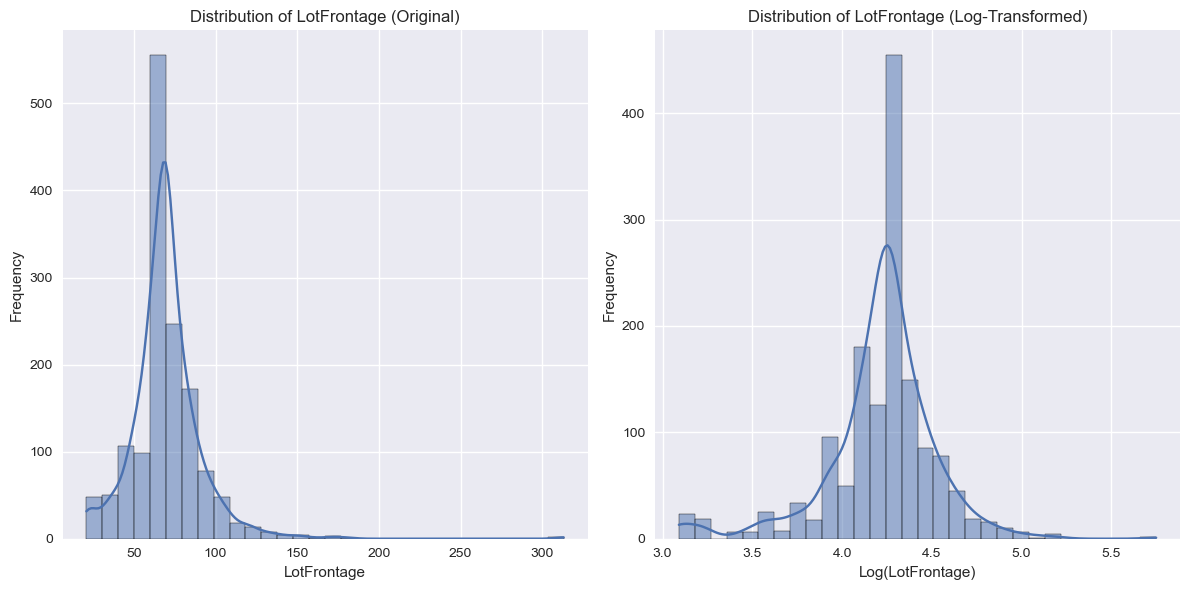

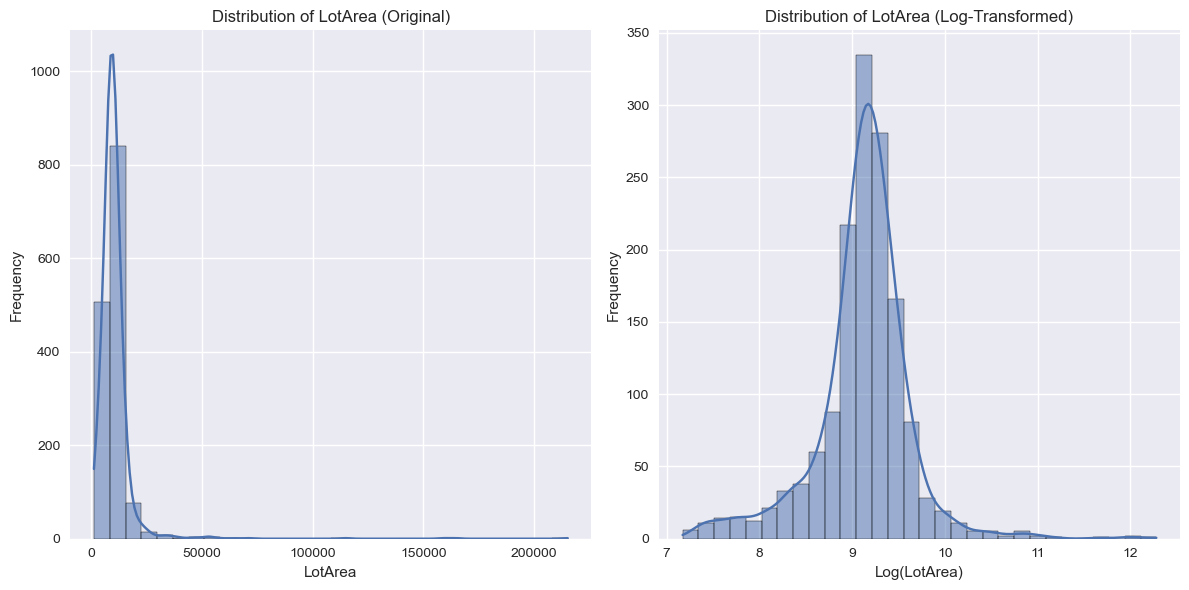

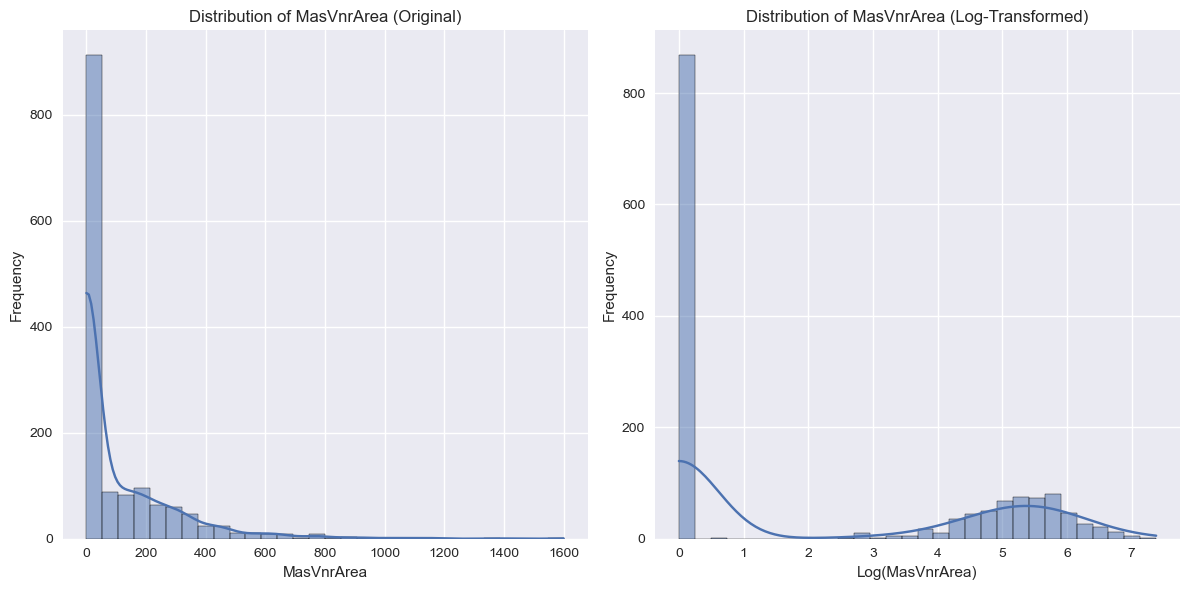

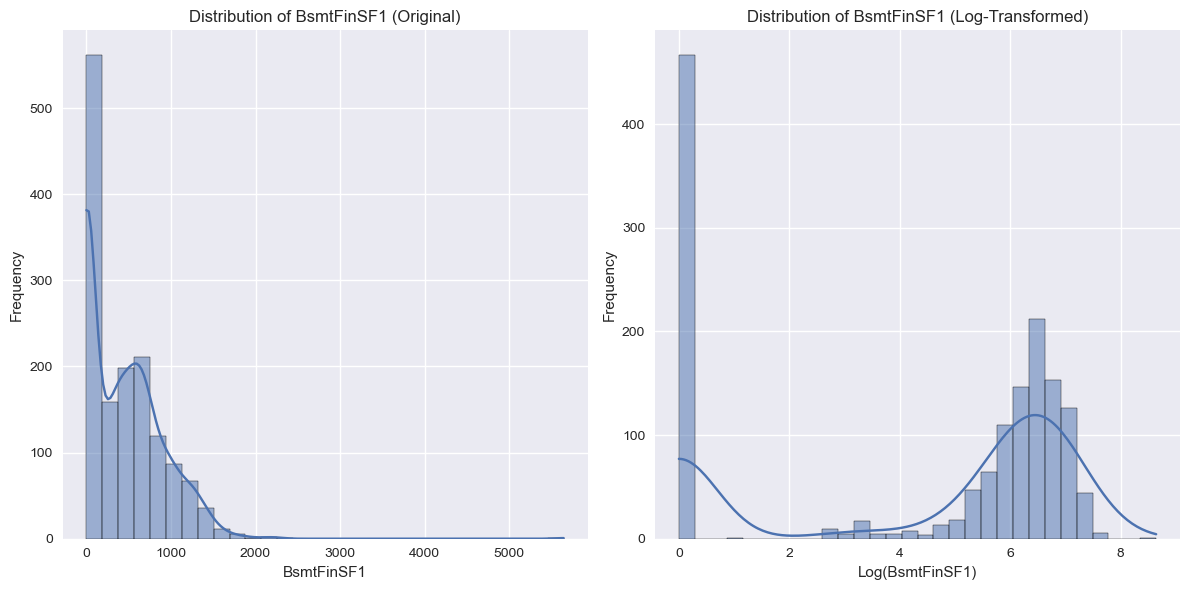

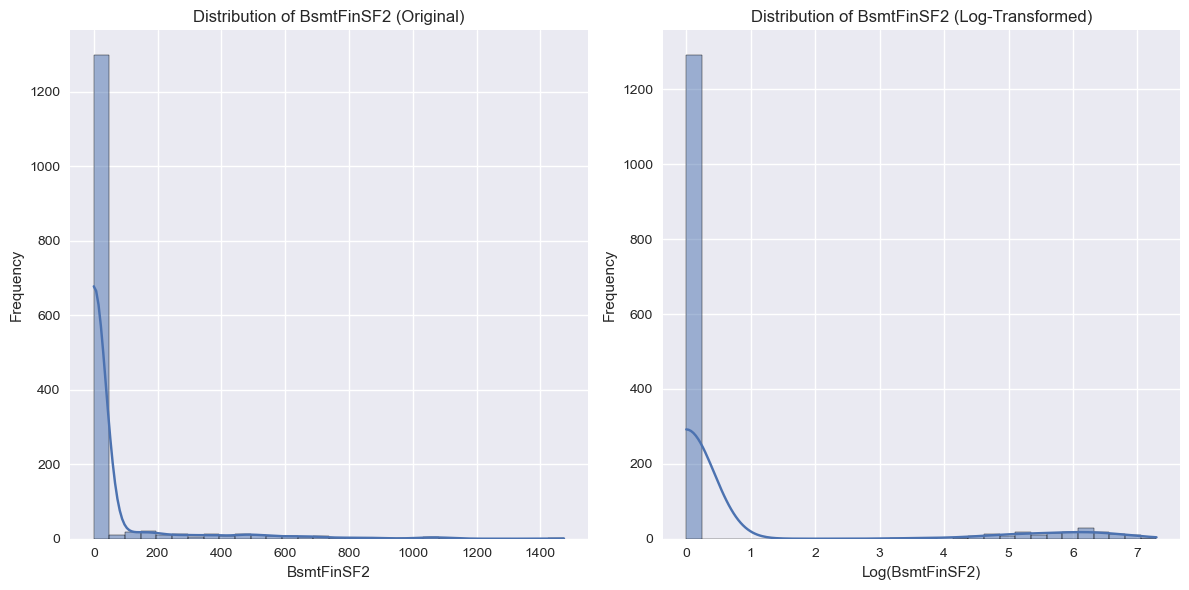

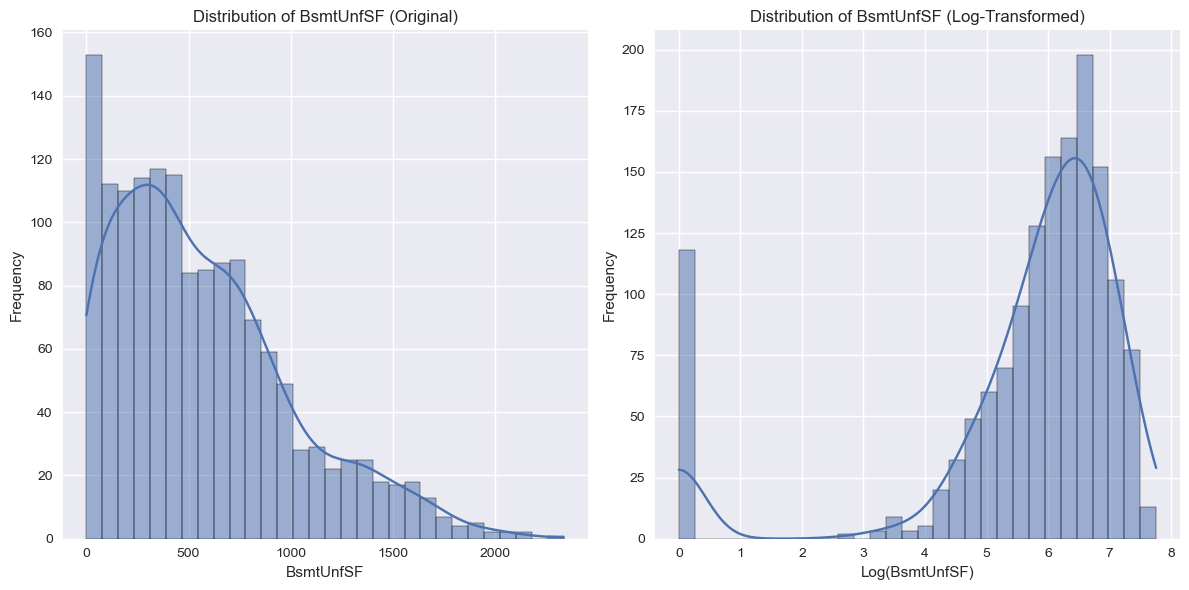

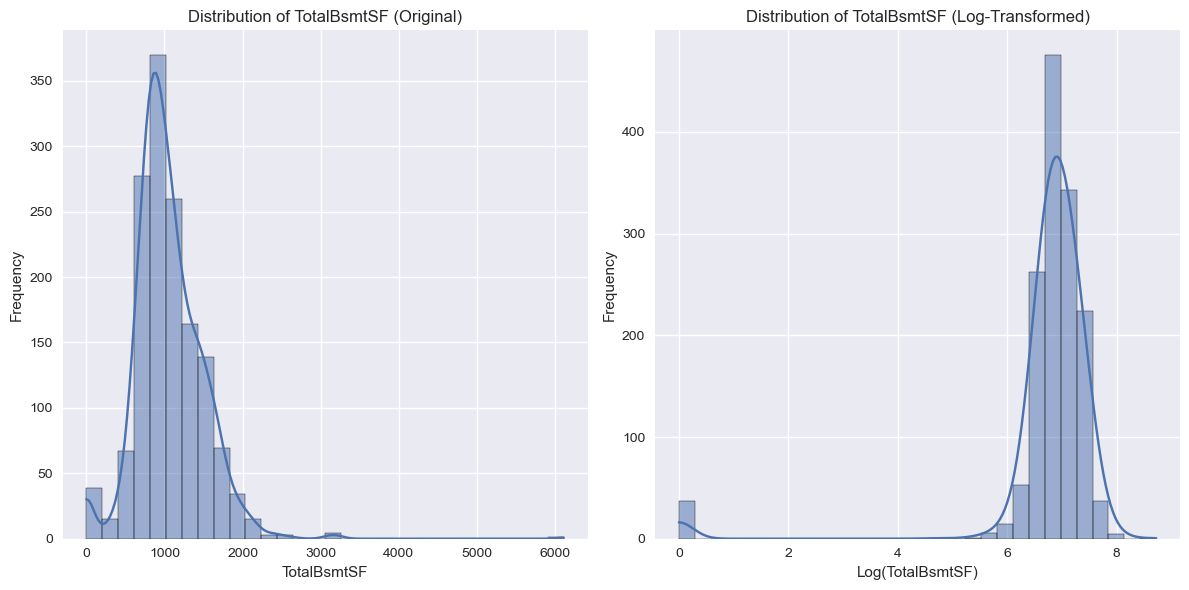

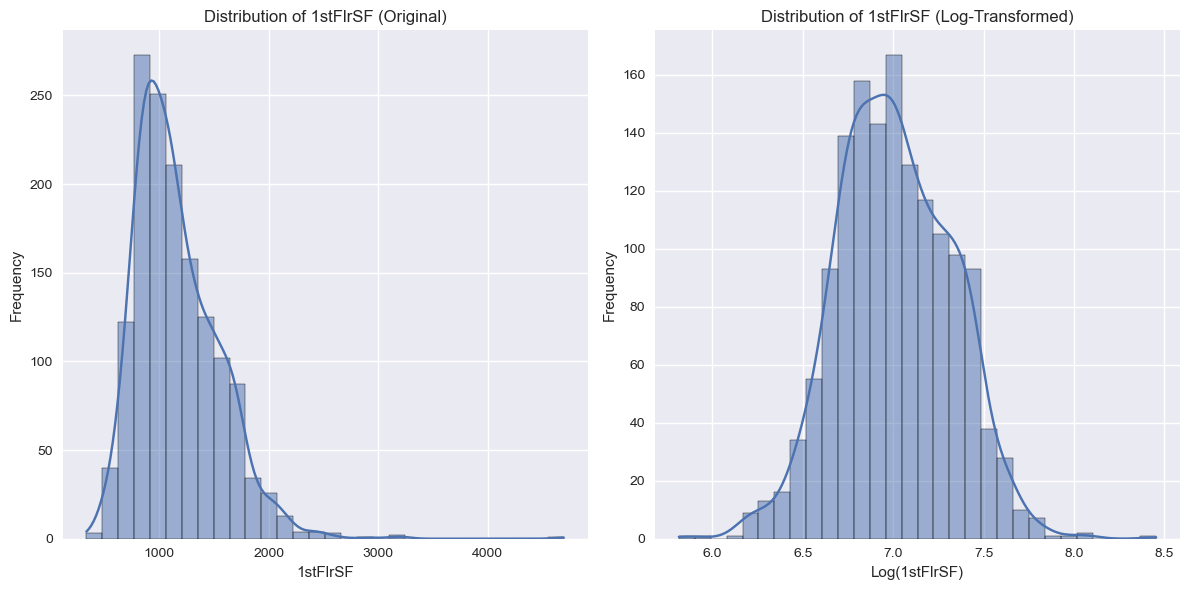

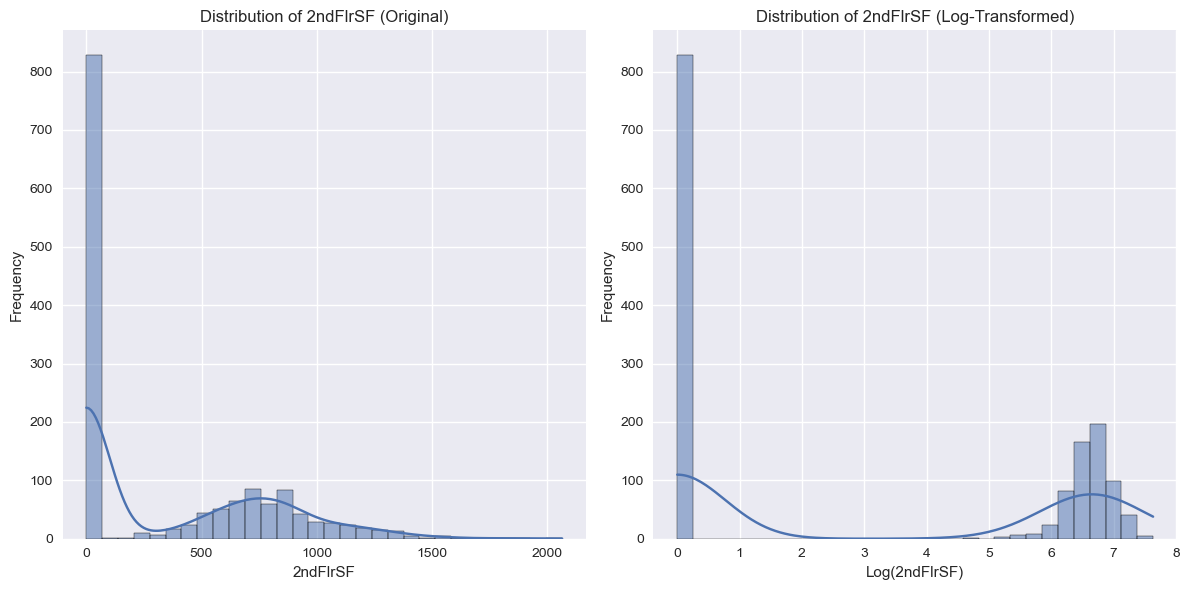

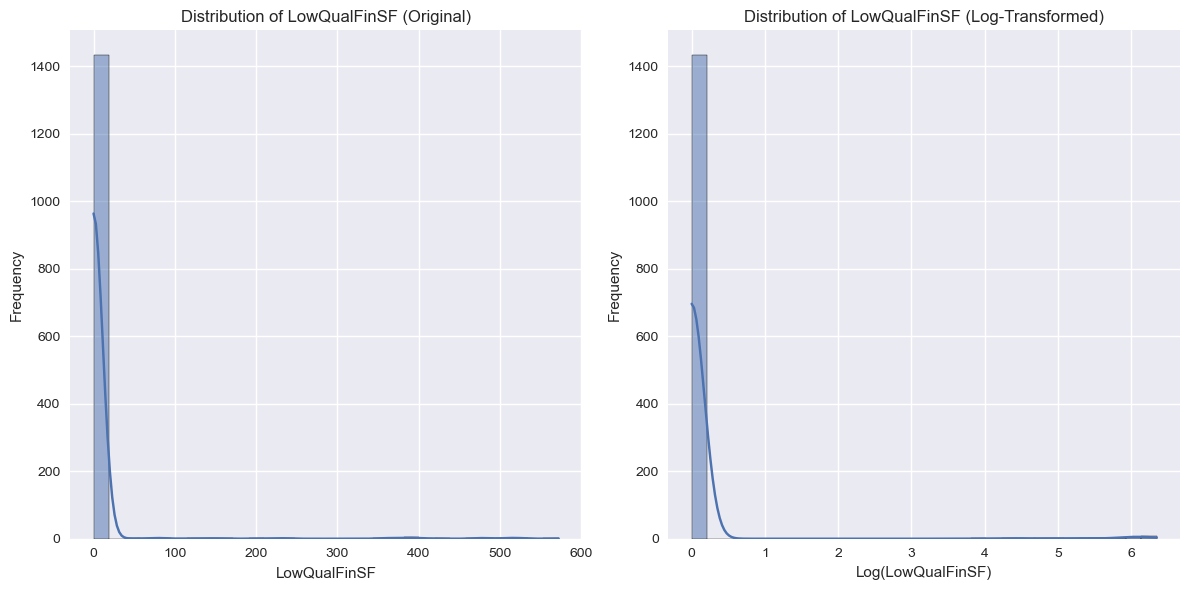

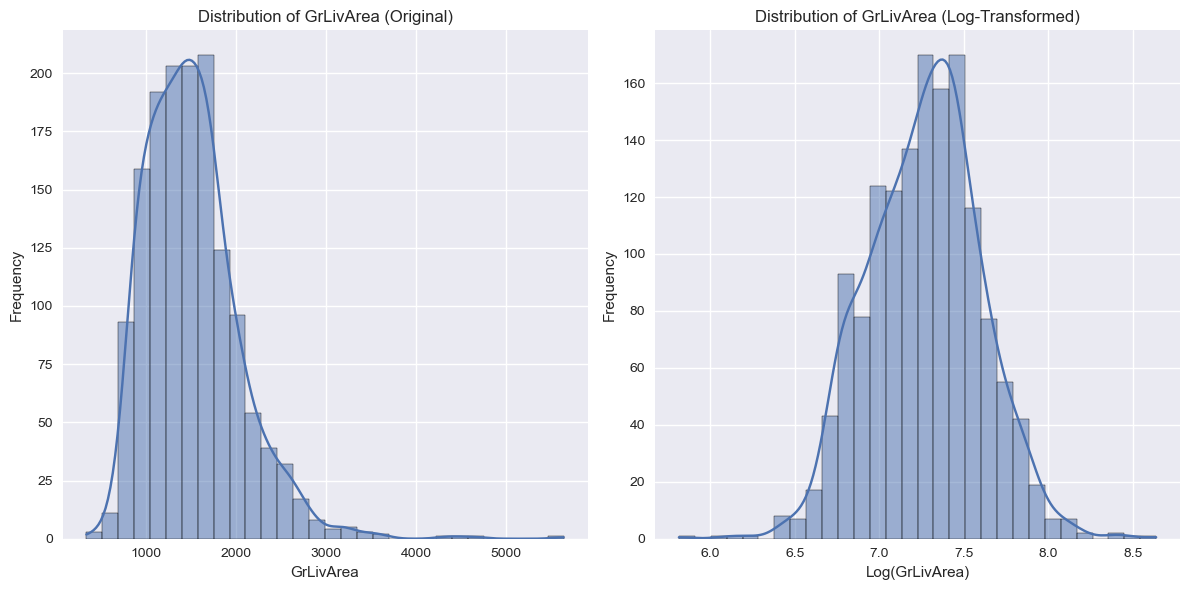

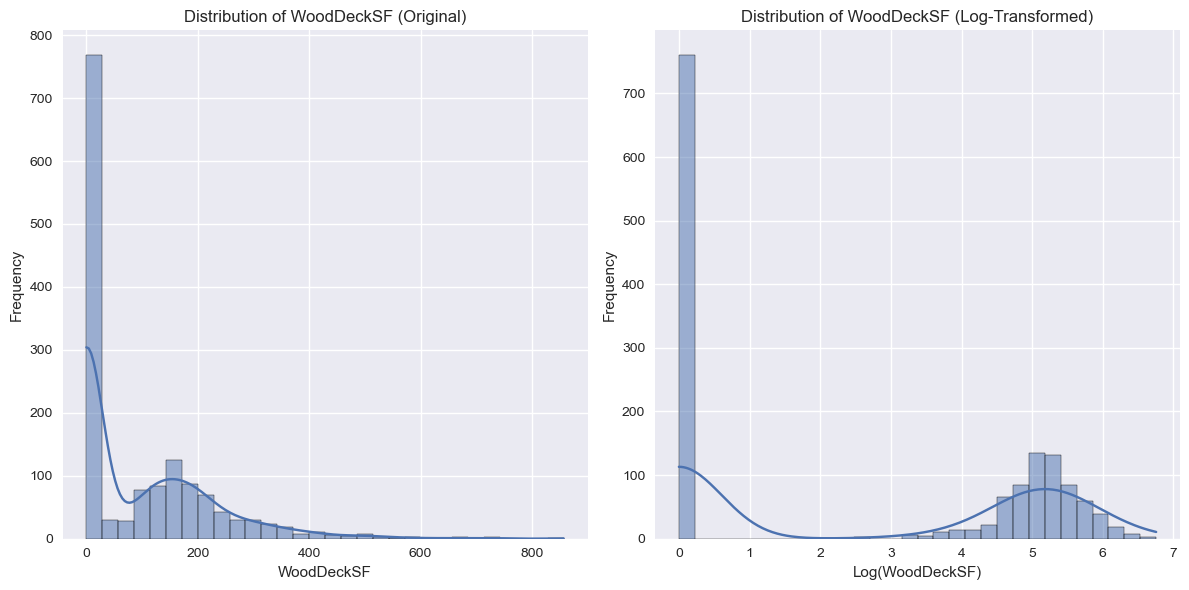

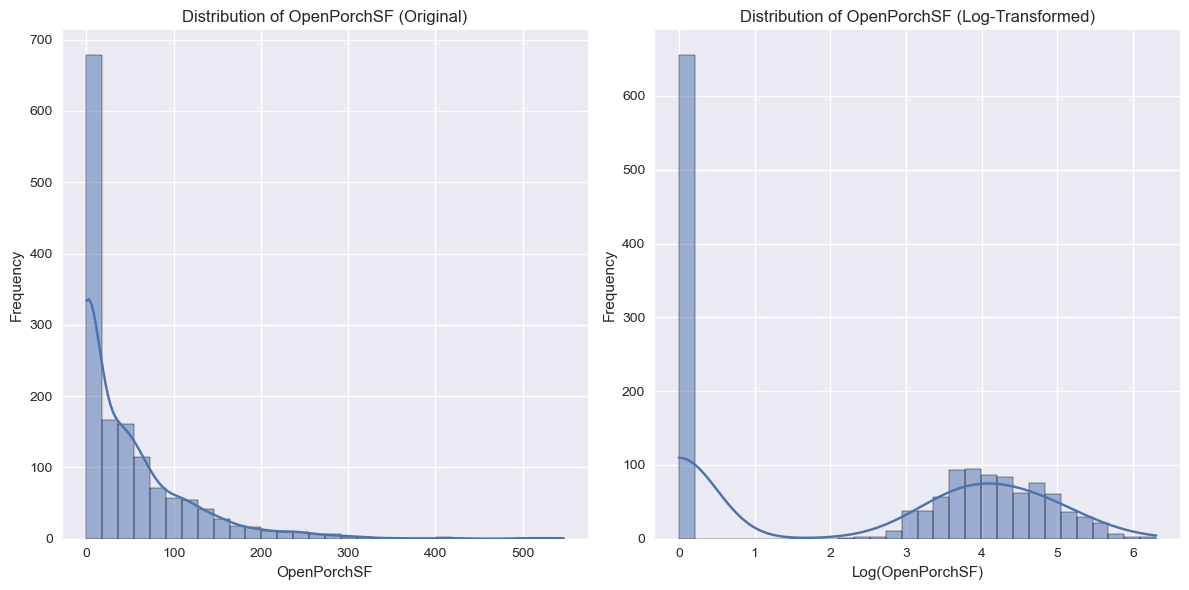

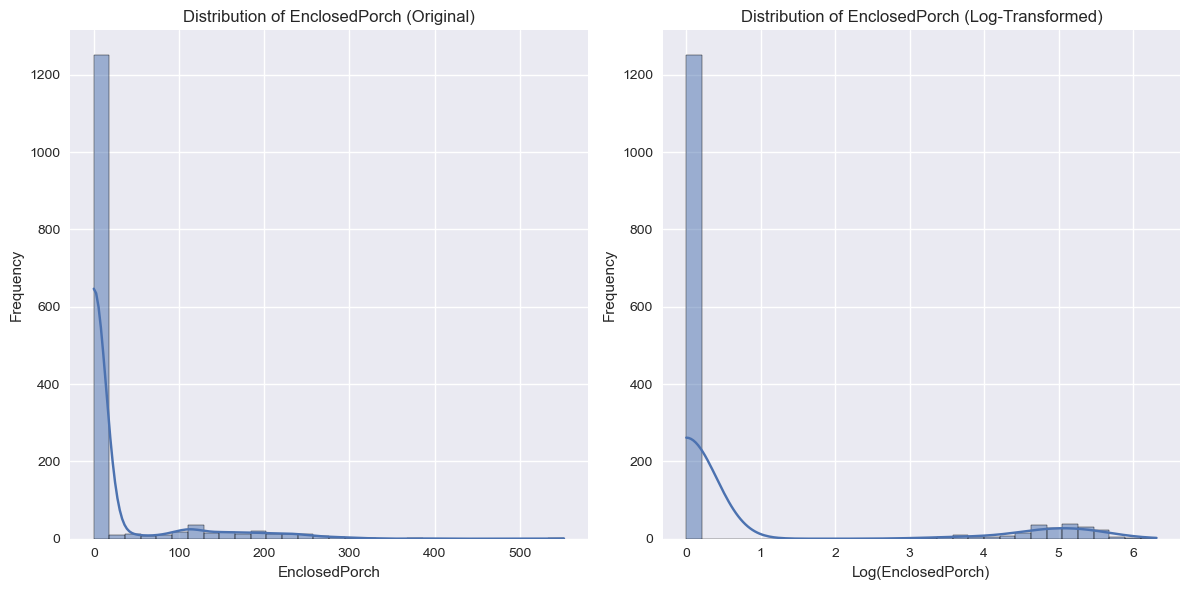

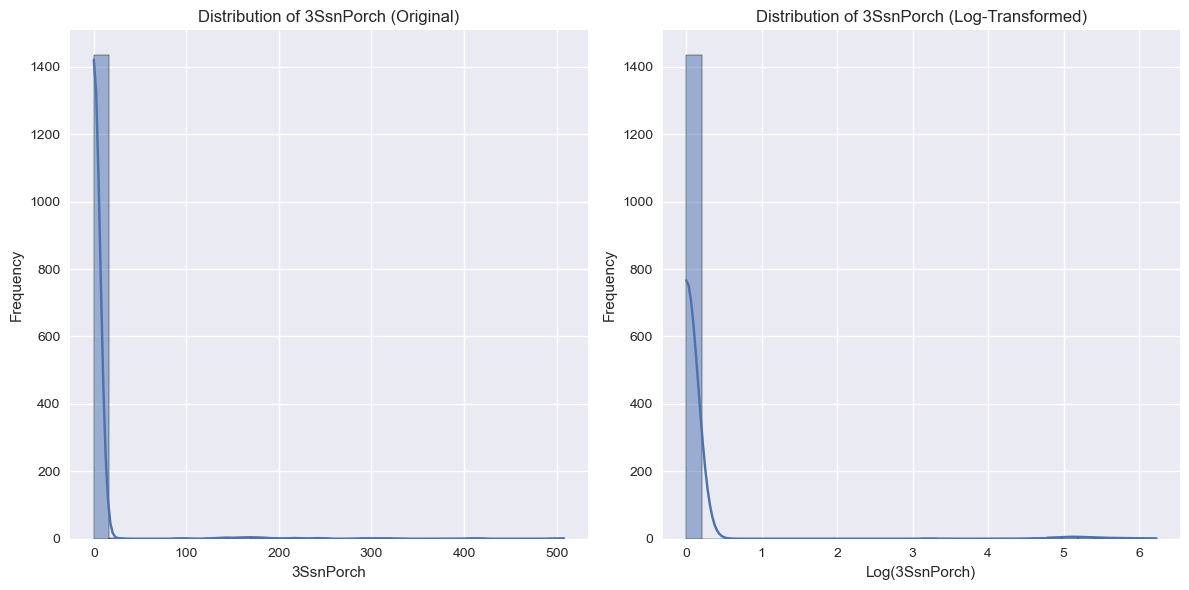

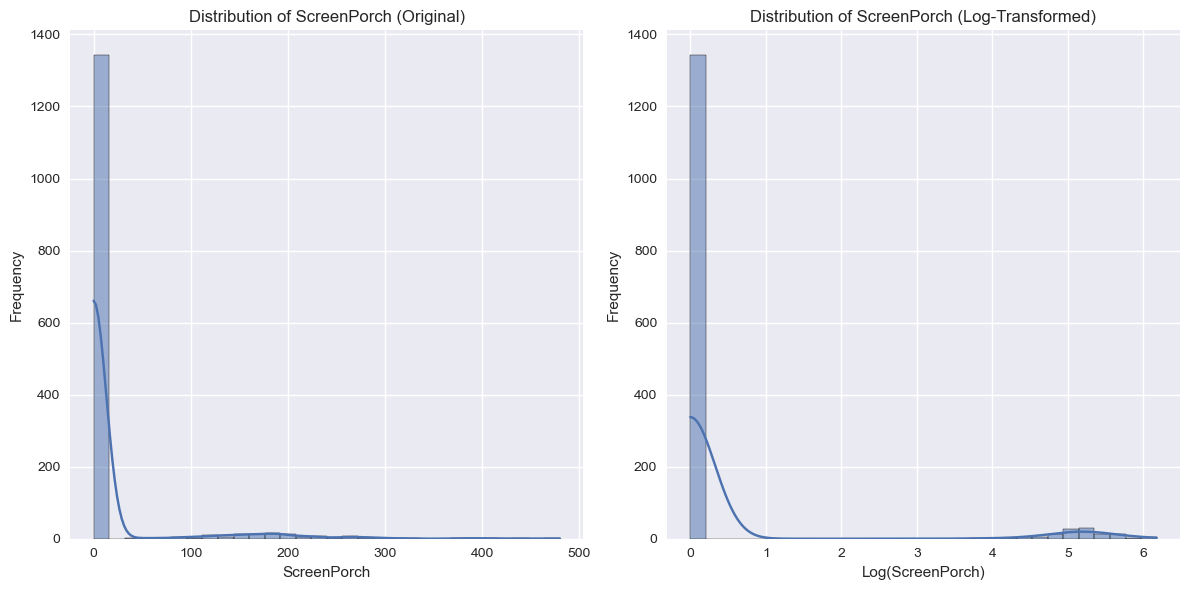

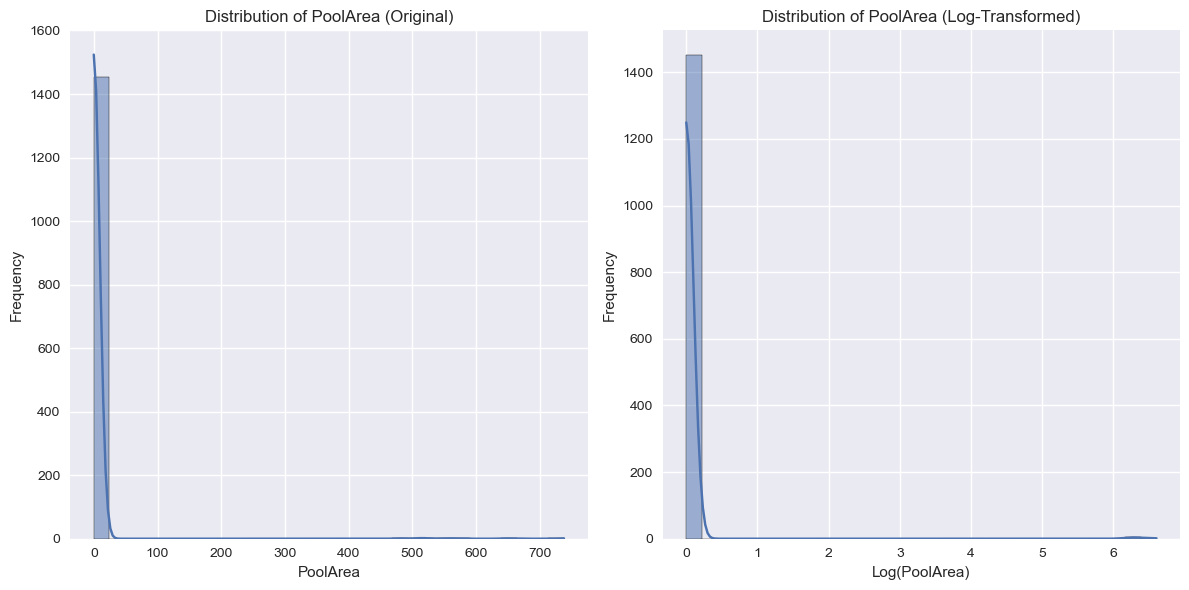

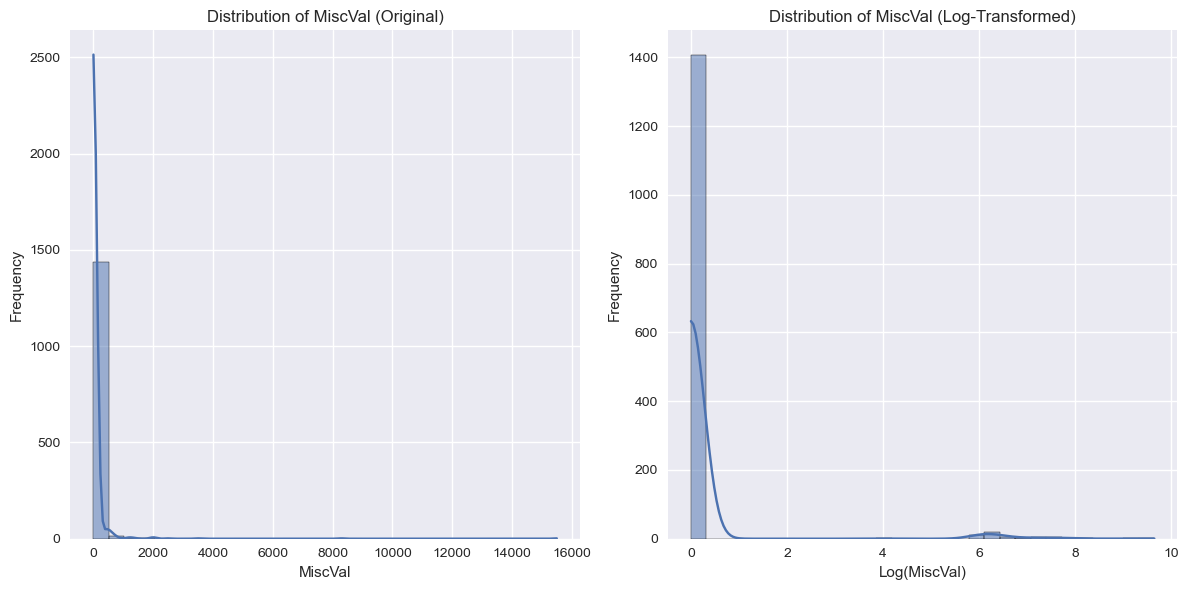

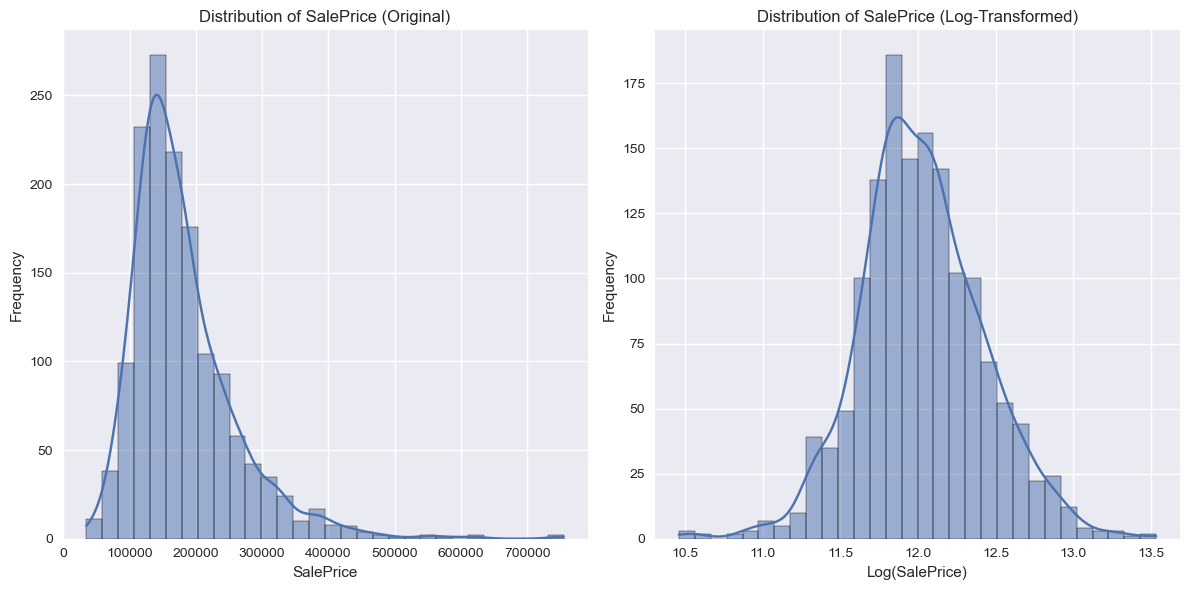

In [431]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of variables to log-transform
variables_to_transform = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF','2ndFlrSF', 'LowQualFinSF', 'GrLivArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                      'ScreenPorch', 'PoolArea', 'MiscVal','SalePrice']

# Function to plot distributions before and after log transformation
def plot_distributions(df, variables):
    for var in variables:
        # Plot original distribution
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(df[var].dropna(), bins=30, kde=True)
        plt.title(f'Distribution of {var} (Original)')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        
        # Apply log transformation (add 1 to avoid log(0))
        log_transformed_var = np.log1p(df[var])
        
        # Plot log-transformed distribution
        plt.subplot(1, 2, 2)
        sns.histplot(log_transformed_var.dropna(), bins=30, kde=True)
        plt.title(f'Distribution of {var} (Log-Transformed)')
        plt.xlabel(f'Log({var})')
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()

# Plot distributions
plot_distributions(df, variables_to_transform)


In [432]:
# Define year columns
year_columns = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

# Convert year columns to datetime then to year
for col in year_columns:
    df[col] = pd.to_datetime(df[col], format='%Y').dt.year


In [433]:
# Confirm results

# 1. Check data types
print("Data types after conversion:")
print(df[year_columns].dtypes)
print("\n")



# 2. Check summary statistics for year columns
print("Summary statistics for year columns:")
print(df[year_columns].describe())

Data types after conversion:
YearBuilt       int64
YearRemodAdd    int64
GarageYrBlt     int64
YrSold          int64
dtype: object


Summary statistics for year columns:
         YearBuilt  YearRemodAdd  GarageYrBlt       YrSold
count  1460.000000   1460.000000  1460.000000  1460.000000
mean   1971.267808   1984.865753  1978.589041  2007.815753
std      30.202904     20.645407    23.997022     1.328095
min    1872.000000   1950.000000  1900.000000  2006.000000
25%    1954.000000   1967.000000  1962.000000  2007.000000
50%    1973.000000   1994.000000  1980.000000  2008.000000
75%    2000.000000   2004.000000  2001.000000  2009.000000
max    2010.000000   2010.000000  2010.000000  2010.000000


In [434]:
# Define categorical features
categorical_features = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'MSSubClass' ]

# Convert categorical variables to 'category' type
for feature in categorical_features:
    df[feature] = df[feature].astype('category')

In [435]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[categorical_features])
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

# Create a new dataframe with encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)

# Concatenate with original dataframe
df = pd.concat([df, encoded_df], axis=1)

In [436]:
# Check unique values for categorical variables
for feature in categorical_features:
    print(f"Unique values in {feature}:")
    print(df[feature].unique())
    print("\n")

Unique values in MSZoning:
['RL', 'RM', 'C (all)', 'FV', 'RH']
Categories (5, object): ['C (all)', 'FV', 'RH', 'RL', 'RM']


Unique values in Street:
['Pave', 'Grvl']
Categories (2, object): ['Grvl', 'Pave']


Unique values in LotShape:
['Reg', 'IR1', 'IR2', 'IR3']
Categories (4, object): ['IR1', 'IR2', 'IR3', 'Reg']


Unique values in LandContour:
['Lvl', 'Bnk', 'Low', 'HLS']
Categories (4, object): ['Bnk', 'HLS', 'Low', 'Lvl']


Unique values in Utilities:
['AllPub', 'NoSeWa']
Categories (2, object): ['AllPub', 'NoSeWa']


Unique values in LotConfig:
['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3']
Categories (5, object): ['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside']


Unique values in LandSlope:
['Gtl', 'Mod', 'Sev']
Categories (3, object): ['Gtl', 'Mod', 'Sev']


Unique values in Neighborhood:
['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', ..., 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU', 'Blueste']
Length: 25
Categories (25, object): ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', .

In [437]:
remaining_categorical_columns = df.select_dtypes(include=['object']).columns
print("Remaining categorical columns:", remaining_categorical_columns)

Remaining categorical columns: Index(['Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')


In [438]:
from sklearn.preprocessing import OneHotEncoder

# Identify remaining categorical columns
remaining_categorical_columns = df.select_dtypes(include=['object']).columns

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the remaining categorical columns
encoded_features = encoder.fit_transform(df[remaining_categorical_columns])
encoded_feature_names = encoder.get_feature_names_out(remaining_categorical_columns)

# Create a new dataframe with encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)

# Concatenate with the original dataframe
df = pd.concat([df, encoded_df], axis=1)

# Drop the original remaining categorical columns
df.drop(columns=remaining_categorical_columns, inplace=True)


In [439]:
# Ensure all categorical variables are encoded
assert df.select_dtypes(include=['object']).empty, "There are still unencoded categorical variables in the DataFrame"


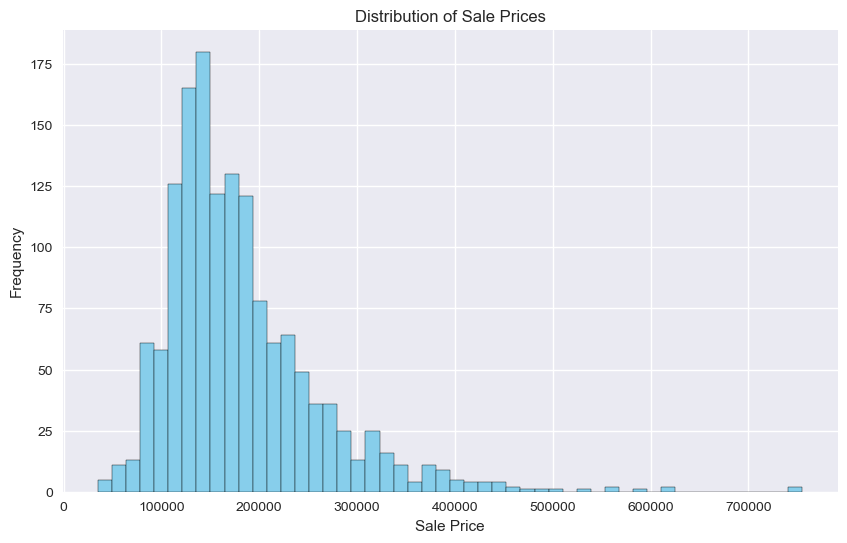

In [440]:
# Sale Price Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['SalePrice'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.savefig('matplotlib_sale_price_distribution.png')
plt.show()

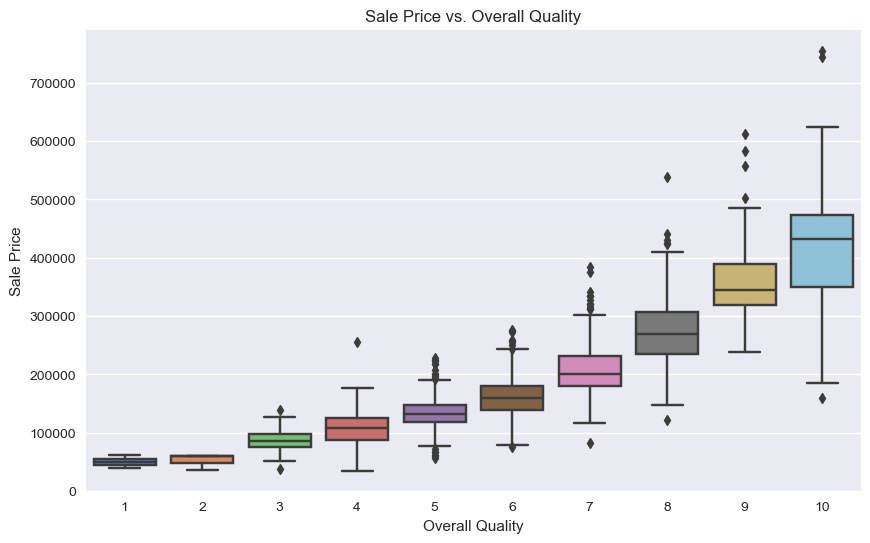

In [441]:
# Sale Price vs. Overall Quality
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=df, palette='muted')
plt.title('Sale Price vs. Overall Quality')
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price')
plt.savefig('seaborn_sale_price_vs_quality.png')
plt.show()


In [442]:
import plotly.express as px
import plotly.graph_objects as go

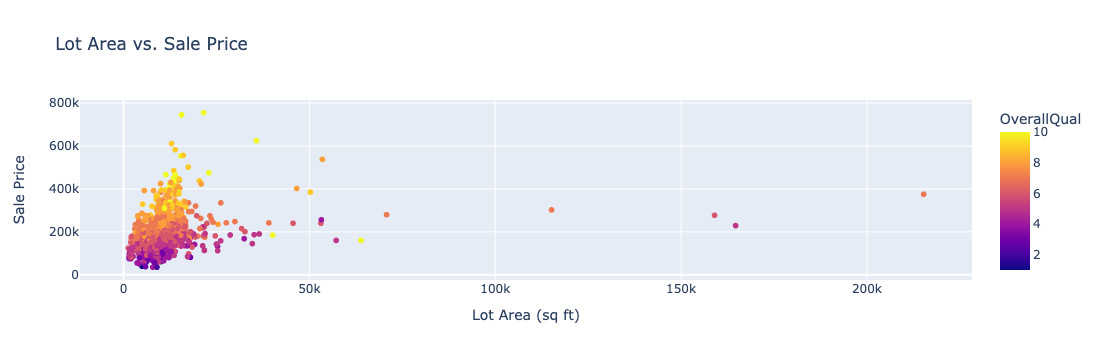

In [443]:
# Create a scatter plot using Plotly
fig = px.scatter(df, x='LotArea', y='SalePrice', color='OverallQual',
                 title='Lot Area vs. Sale Price',
                 labels={'LotArea': 'Lot Area (sq ft)', 'SalePrice': 'Sale Price'},
                 hover_data=['YearBuilt'])

# Display the plot
fig.show()

# Save the plot as a PNG image
fig.write_image('plotly_lot_area_vs_sale_price.png')



Top correlated features with SalePrice:
 Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'ExterQual_TA', 'FullBath', 'BsmtQual_Ex',
       'TotRmsAbvGrd'],
      dtype='object')


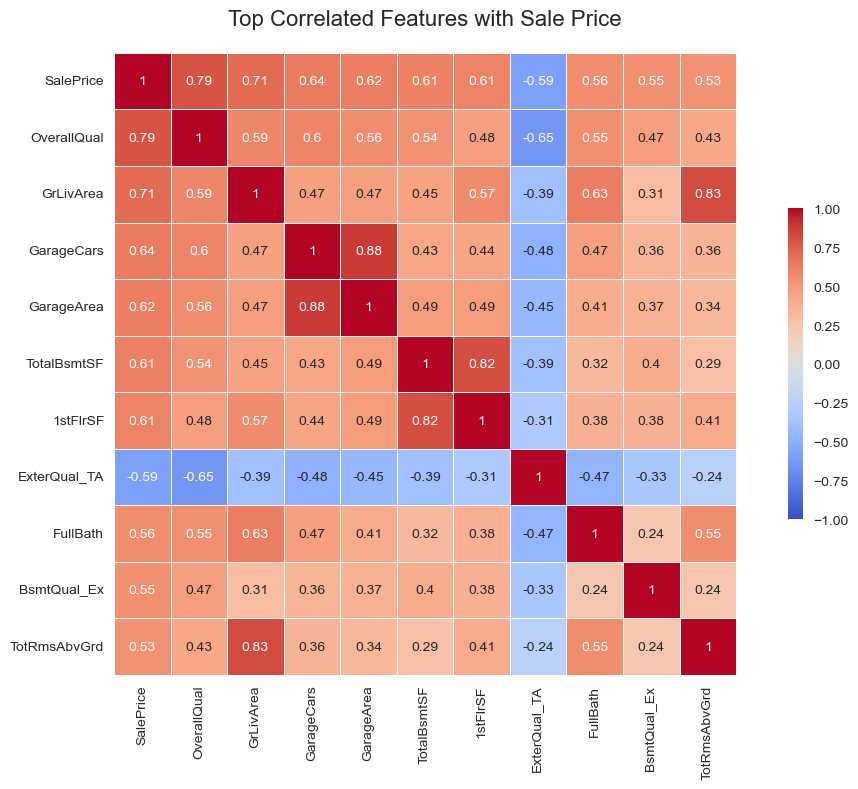

In [487]:


# Compute the correlation matrix
corr_matrix = df.corr()

# Select the top features that correlate with 'SalePrice'
top_corr_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(11).index
print("Top correlated features with SalePrice:\n", top_corr_features)

# Create a new correlation matrix with the top features
top_corr_matrix = df[top_corr_features].corr()

# Create the heatmap
plt.figure(figsize=(11, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, square=True, 
            linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Top Correlated Features with Sale Price', fontsize=16, pad=20)
plt.tight_layout()

# Save the plot
plt.savefig('seaborn_top_corr_heatmap.png')

# Display the plot
plt.show()


In [491]:
# Creating New Features
# Total square footage of the house
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

In [493]:
# Age of the house
df['HouseAge'] = df['YrSold'] - df['YearBuilt']

In [497]:
# Time since last remodel
df['RemodelAge'] = df['YrSold'] - df['YearRemodAdd']

In [519]:
# Interaction between TotalSF and OverallQual
df['TotalSF_OverallQual'] = df['TotalSF'] * df['OverallQual']

# Interaction between GrLivArea and TotRmsAbvGrd
df['GrLivArea_TotRmsAbvGrd'] = df['GrLivArea'] * df['TotRmsAbvGrd']

# Interaction between HouseAge and OverallQual
df['HouseAge_OverallQual'] = df['HouseAge'] * df['OverallQual']

# Interaction between GarageArea and GarageCars
df['GarageArea_GarageCars'] = df['GarageArea'] * df['GarageCars']

# Interaction between YearBuilt and YearRemodAdd
df['YearBuilt_YearRemodAdd'] = df['YearBuilt'] * df['YearRemodAdd']

# Interaction between TotalSF and HouseAge
df['TotalSF_HouseAge'] = df['TotalSF'] * df['HouseAge']

# Interaction between 1stFlrSF and 2ndFlrSF
df['1stFlrSF_2ndFlrSF'] = df['1stFlrSF'] * df['2ndFlrSF']

# Interaction between LotArea and Neighborhood
df['Neighborhood'] = df['Neighborhood'].astype('category').cat.codes
df['LotArea_Neighborhood'] = df['LotArea'] * df['Neighborhood']


In [521]:
from sklearn.preprocessing import StandardScaler

# Standard scaling of numerical features
scaler = StandardScaler()
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_features] = scaler.fit_transform(df[numerical_features])


In [523]:
from sklearn.preprocessing import MinMaxScaler

# MinMax scaling of numerical features
scaler = MinMaxScaler()
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_features] = scaler.fit_transform(df[numerical_features])
